# PCA on Vibration Data
This notebook loads all RECOVERY.npz files, performs PCA to reduce the data to 2 dimensions, and visualizes the results labeled by cube position.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path
import sys
import types
import os
import re
from glob import glob
from scipy.signal import butter, sosfiltfilt

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# =============================================================================
# CONFIGURATION FLAGS
# =============================================================================
# Bandpass filtering options
APPLY_BANDPASS_FILTER = True  # Set to True to apply bandpass filtering to shift data
FILTER_LOWCUT = 50             # Lower cutoff frequency (Hz)
FILTER_HIGHCUT = None          # Upper cutoff frequency (Hz), None = fs/2 - 10
FILTER_ORDER = 5               # Filter order

# Feature extraction options
USE_FFT = False                 # Set to True to use FFT magnitude spectrum as features
                               # Set to False to use raw flattened time series

# =============================================================================
# Filter functions
# =============================================================================
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter(order, [lowcut, highcut], fs=fs, btype='band', output='sos')
    return sosfiltfilt(sos, data)

def filter_shifts(shifts, fs, lowcut=50, highcut=None, order=5):
    if highcut is None:
        highcut = fs / 2 - 10  # Slightly below Nyquist frequency
    filtered_shifts = np.empty_like(shifts)
    for i in range(shifts.shape[0]):
        for j in range(shifts.shape[2]):
            filtered_shifts[i, :, j] = bandpass_filter(shifts[i, :, j], lowcut, highcut, fs, order)
    return filtered_shifts

print("=" * 60)
print("CONFIGURATION")
print("=" * 60)
print(f"Bandpass filtering: {'ENABLED' if APPLY_BANDPASS_FILTER else 'DISABLED'}")
if APPLY_BANDPASS_FILTER:
    print(f"  - Lowcut: {FILTER_LOWCUT} Hz")
    print(f"  - Highcut: {FILTER_HIGHCUT if FILTER_HIGHCUT else 'auto (fs/2 - 10)'}")
    print(f"  - Order: {FILTER_ORDER}")
print(f"Feature extraction: {'FFT magnitude spectrum' if USE_FFT else 'Raw time series'}")
print("=" * 60)

CONFIGURATION
Bandpass filtering: ENABLED
  - Lowcut: 50 Hz
  - Highcut: auto (fs/2 - 10)
  - Order: 5
Feature extraction: Raw time series


## Load all RECOVERY.npz files

In [2]:
# Patch for pickle loading
def compute_CAM2_translations_v3_cupy(*args, **kwargs):
    return None

if 'recover_core_lib' in sys.modules:
    sys.modules['recover_core_lib'].compute_CAM2_translations_v3_cupy = compute_CAM2_translations_v3_cupy
else:
    fake = types.ModuleType('recover_core_lib')
    fake.compute_CAM2_translations_v3_cupy = compute_CAM2_translations_v3_cupy
    sys.modules['recover_core_lib'] = fake

# Find all RECOVERY.npz files
data_dir = Path('/Users/eitanturok/good-vibrations/data/vibrations')
recovery_files = sorted(glob(str(data_dir / '*/RECOVERY.npz')))

print(f"Found {len(recovery_files)} RECOVERY.npz files:")
for f in recovery_files:
    print(f"  - {f}")

Found 8 RECOVERY.npz files:
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos1_29_12_Time_19_16_40/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos2_29_12_Time_19_03_39/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos2_29_12_Time_19_13_50/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos3_29_12_Time_19_27_21/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos3_29_12_Time_19_29_43/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos4_29_12_Time_19_24_21/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos5_29_12_Time_19_22_12/RECOVERY.npz
  - /Users/eitanturok/good-vibrations/data/vibrations/cube_pos6_29_12_Time_19_20_07/RECOVERY.npz


In [3]:
def extract_cube_position(filepath):
    """Extract cube position from filepath like 'cube_pos1_29_12_Time_19_16_40'"""
    dirname = Path(filepath).parent.name
    match = re.search(r'cube_pos(\d+)', dirname)
    if match:
        return int(match.group(1))
    return None

# Load all data
all_data = []
all_positions = []
all_filenames = []

for filepath in recovery_files:
    recovery_data = np.load(filepath, allow_pickle=True)
    all_shifts = recovery_data['all_shifts']
    run_opt = recovery_data['run_opt'].item()
    fs = run_opt['cam_params']['camera_FPS']

    # Remove first time point if needed (based on original notebook)
    all_shifts = all_shifts[:, 1:]

    # Apply bandpass filter if enabled
    if APPLY_BANDPASS_FILTER:
        all_shifts = filter_shifts(all_shifts, fs=fs, lowcut=FILTER_LOWCUT,
                                   highcut=FILTER_HIGHCUT, order=FILTER_ORDER)

    cube_pos = extract_cube_position(filepath)

    all_data.append(all_shifts)
    all_positions.append(cube_pos)
    all_filenames.append(filepath)

    print(f"Loaded {filepath}")
    print(f"  - Cube position: {cube_pos}")
    print(f"  - Shape: {all_shifts.shape}")
    print(f"  - fs: {fs} Hz")
    if APPLY_BANDPASS_FILTER:
        print(f"  - Filtered: {FILTER_LOWCUT}-{FILTER_HIGHCUT if FILTER_HIGHCUT else int(fs/2 - 10)} Hz")
    print()

Loaded /Users/eitanturok/good-vibrations/data/vibrations/cube_pos1_29_12_Time_19_16_40/RECOVERY.npz
  - Cube position: 1
  - Shape: (100, 29999, 2)
  - fs: 5000 Hz
  - Filtered: 50-2490 Hz

Loaded /Users/eitanturok/good-vibrations/data/vibrations/cube_pos2_29_12_Time_19_03_39/RECOVERY.npz
  - Cube position: 2
  - Shape: (100, 29999, 2)
  - fs: 5000 Hz
  - Filtered: 50-2490 Hz

Loaded /Users/eitanturok/good-vibrations/data/vibrations/cube_pos2_29_12_Time_19_13_50/RECOVERY.npz
  - Cube position: 2
  - Shape: (100, 29999, 2)
  - fs: 5000 Hz
  - Filtered: 50-2490 Hz

Loaded /Users/eitanturok/good-vibrations/data/vibrations/cube_pos3_29_12_Time_19_27_21/RECOVERY.npz
  - Cube position: 3
  - Shape: (100, 29999, 2)
  - fs: 5000 Hz
  - Filtered: 50-2490 Hz

Loaded /Users/eitanturok/good-vibrations/data/vibrations/cube_pos3_29_12_Time_19_29_43/RECOVERY.npz
  - Cube position: 3
  - Shape: (100, 29999, 2)
  - fs: 5000 Hz
  - Filtered: 50-2490 Hz

Loaded /Users/eitanturok/good-vibrations/data/vibr

## Prepare data for PCA
Flatten each recording into a single feature vector and stack them together.

In [4]:
# Build feature vectors from shift data
# Uses USE_FFT flag from configuration section above

feature_vectors = []

for shifts in all_data:
    # shifts shape: (n_sensors, n_timesteps, 2)
    n_sensors, n_timesteps, n_dims = shifts.shape

    if USE_FFT:
        # Compute FFT magnitude for each sensor/dimension
        fft_mag = np.abs(np.fft.rfft(shifts, axis=1))
        # Flatten: (n_sensors * n_freq_bins * 2)
        feature_vec = fft_mag.flatten()
    else:
        # Flatten the raw time series
        feature_vec = shifts.flatten()

    feature_vectors.append(feature_vec)

# Find minimum length and truncate to make uniform
min_len = min(len(fv) for fv in feature_vectors)
feature_vectors = [fv[:min_len] for fv in feature_vectors]

# Stack into matrix
X = np.vstack(feature_vectors)
positions = np.array(all_positions)

print(f"Feature extraction: {'FFT magnitude' if USE_FFT else 'Raw time series'}")
print(f"Feature matrix shape: {X.shape}")
print(f"Positions: {positions}")

Feature extraction: Raw time series
Feature matrix shape: (8, 5999800)
Positions: [1 2 2 3 3 4 5 6]


## Perform PCA

In [5]:
# Standardize features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1  # Avoid division by zero
X_normalized = (X - X_mean) / X_std

# PCA to 2 dimensions
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_normalized)

print(f"PCA result shape: {X_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

PCA result shape: (8, 2)
Explained variance ratio: [0.18727638 0.16987601]
Total variance explained: 35.72%


## Visualize PCA results

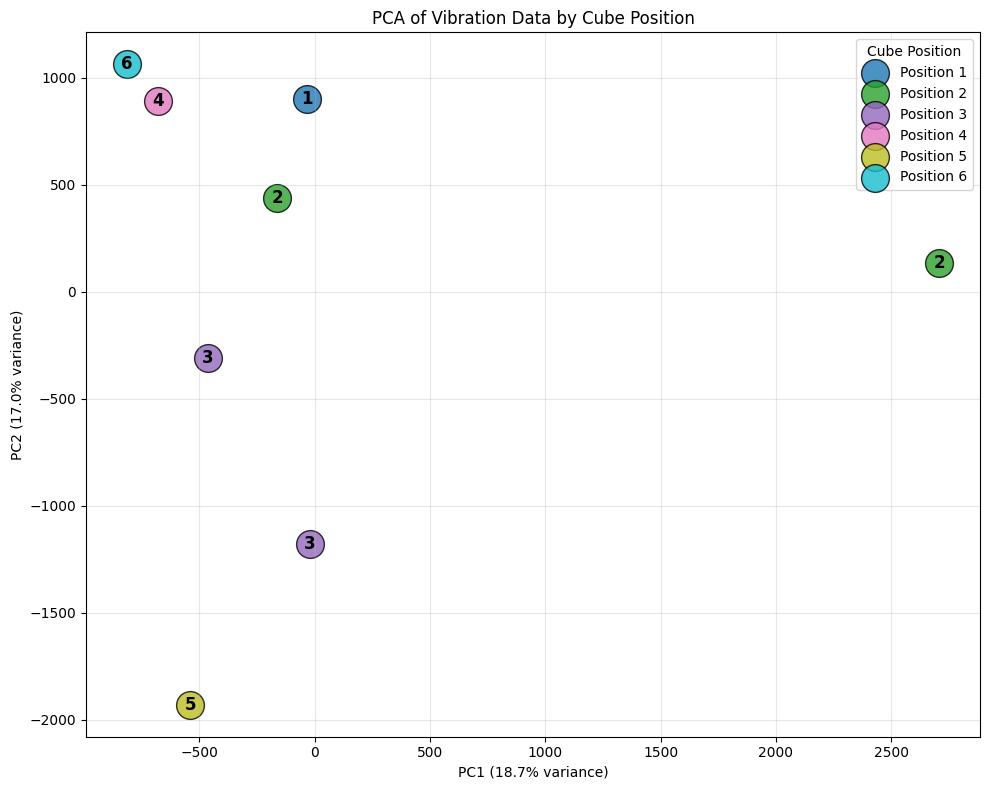

In [6]:
# Create color map for cube positions
unique_positions = np.unique(positions)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_positions)))
color_map = {pos: colors[i] for i, pos in enumerate(unique_positions)}

fig, ax = plt.subplots(figsize=(10, 8))

for pos in unique_positions:
    mask = positions == pos
    ax.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        c=[color_map[pos]],
        label=f'Position {pos}',
        s=400,
        alpha=0.8,
        edgecolors='black',
        linewidths=1
    )

# Add position number inside each circle
for i, (x, y) in enumerate(X_pca):
    ax.text(
        x, y, str(positions[i]),
        fontsize=12,
        fontweight='bold',
        ha='center',
        va='center',
        color='black'
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('PCA of Vibration Data by Cube Position')
ax.legend(title='Cube Position', loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Additional visualization: PCA with more components

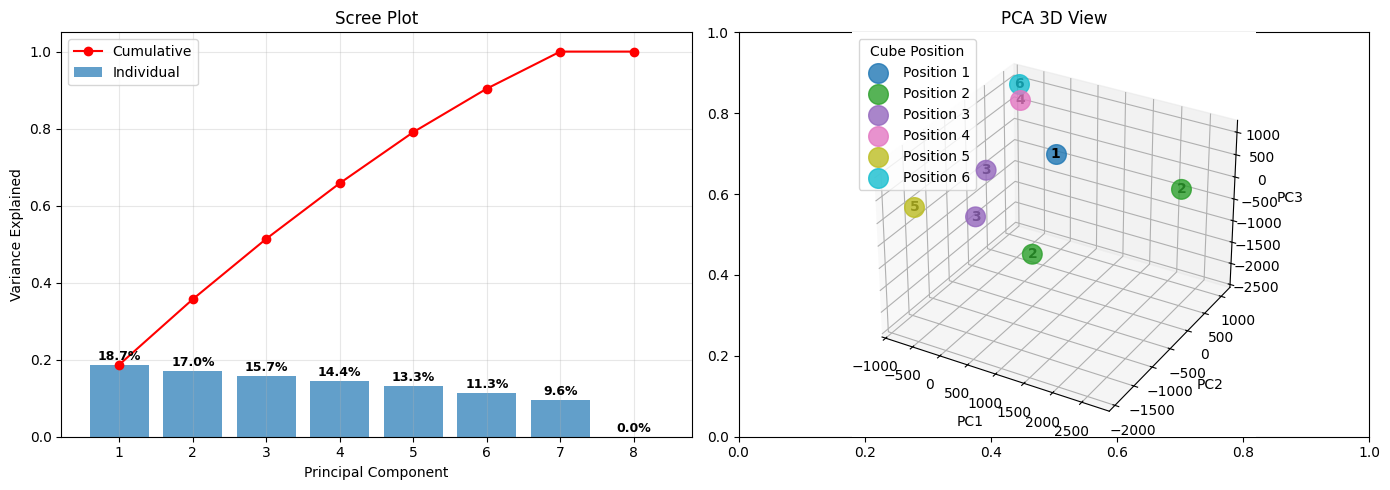

In [7]:
# PCA with more components to see variance explained
pca_full = PCA(n_components=min(8, X.shape[0]), random_state=RANDOM_SEED)
X_pca_full = pca_full.fit_transform(X_normalized)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
ax = axes[0]
bars = ax.bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
              pca_full.explained_variance_ratio_,
              alpha=0.7, label='Individual')
ax.plot(range(1, len(pca_full.explained_variance_ratio_) + 1),
        np.cumsum(pca_full.explained_variance_ratio_),
        'r-o', label='Cumulative')

# Add variance percentage on each bar
for i, (bar, var) in enumerate(zip(bars, pca_full.explained_variance_ratio_)):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
            f'{var:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained')
ax.set_title('Scree Plot')
ax.legend()
ax.grid(True, alpha=0.3)

# 3D plot if we have at least 3 components
if X_pca_full.shape[1] >= 3:
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    for pos in unique_positions:
        mask = positions == pos
        ax.scatter(
            X_pca_full[mask, 0],
            X_pca_full[mask, 1],
            X_pca_full[mask, 2],
            c=[color_map[pos]],
            label=f'Position {pos}',
            s=200,
            alpha=0.8
        )

    # Add position labels to each point
    for i in range(len(positions)):
        ax.text(
            X_pca_full[i, 0],
            X_pca_full[i, 1],
            X_pca_full[i, 2],
            str(positions[i]),
            fontsize=10,
            fontweight='bold',
            ha='center',
            va='center',
            color='black'
        )

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('PCA 3D View')
    ax.legend(title='Cube Position')

plt.tight_layout()
plt.show()

## Summary table

In [8]:
print("Summary of loaded data:")
print("=" * 80)
print(f"{'File':<50} {'Position':<10} {'PC1':>8} {'PC2':>8}")
print("-" * 80)
for i, (fname, pos) in enumerate(zip(all_filenames, positions)):
    dirname = Path(fname).parent.name
    print(f"{dirname:<50} {pos:<10} {X_pca[i, 0]:>8.2f} {X_pca[i, 1]:>8.2f}")
print("=" * 80)

Summary of loaded data:
File                                               Position        PC1      PC2
--------------------------------------------------------------------------------
cube_pos1_29_12_Time_19_16_40                      1            -33.49   900.53
cube_pos2_29_12_Time_19_03_39                      2           2708.42   133.62
cube_pos2_29_12_Time_19_13_50                      2           -162.49   435.33
cube_pos3_29_12_Time_19_27_21                      3           -463.34  -309.54
cube_pos3_29_12_Time_19_29_43                      3            -19.78 -1180.84
cube_pos4_29_12_Time_19_24_21                      4           -676.80   889.70
cube_pos5_29_12_Time_19_22_12                      5           -538.16 -1930.44
cube_pos6_29_12_Time_19_20_07                      6           -814.35  1061.64


## Distance Matrix with Ordering Validation

Constraint: Samples from the same position must be closest to each other in embedding space.
- Position 2 has samples at indices 1 and 2
- Position 3 has samples at indices 3 and 4

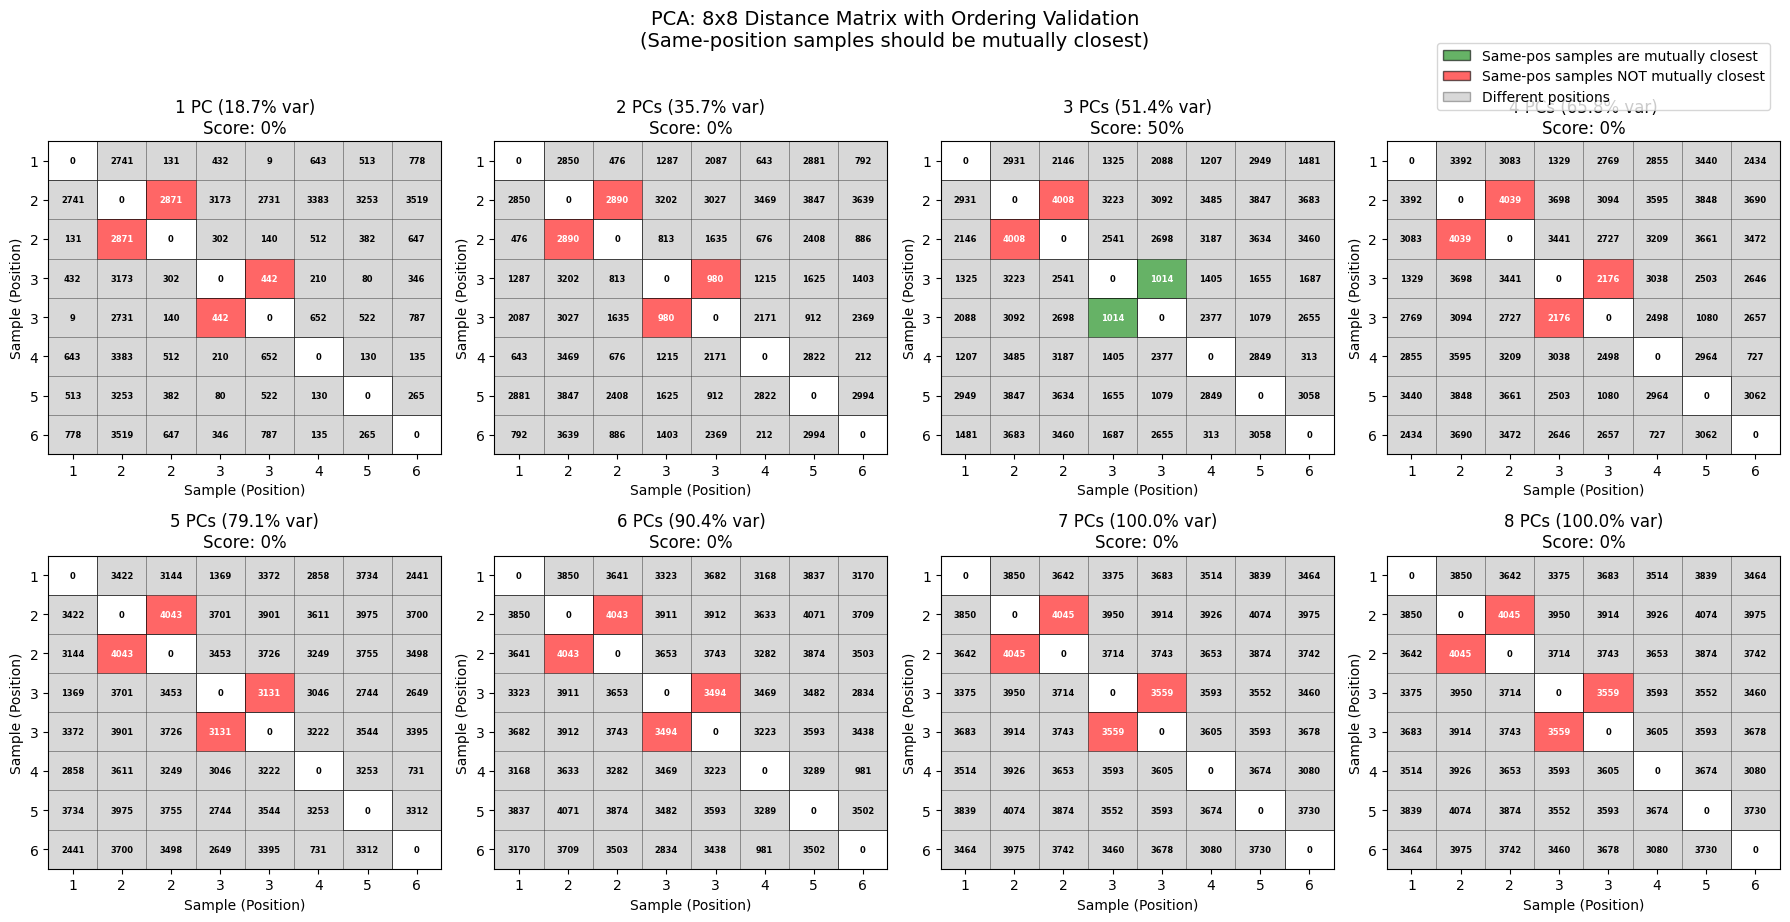


PCA Scores (same-position samples mutually closest):
  1 PC : 0%
  2 PCs: 0%
  3 PCs: 50%
  4 PCs: 0%
  5 PCs: 0%
  6 PCs: 0%
  7 PCs: 0%
  8 PCs: 0%


In [9]:
from scipy.spatial.distance import cdist

def compute_sample_distance_matrix(X_embedded):
    """Compute pairwise distance between all samples in embedded space."""
    return cdist(X_embedded, X_embedded, metric='euclidean')

def check_same_position_closest(dist_matrix, positions):
    """
    Check if samples from the same position are closest to each other.
    Returns: (score, cell_status_matrix)
    - score: fraction of same-position pairs that are mutually closest
    - cell_status_matrix: 1=correct, -1=incorrect, 0=not applicable
    """
    n = len(positions)
    status = np.zeros((n, n))
    n_constraints = 0
    n_correct = 0

    # Find pairs of samples with the same position
    for i in range(n):
        for j in range(i + 1, n):
            if positions[i] == positions[j]:
                n_constraints += 1
                # Check if j is the closest to i (excluding i itself)
                dist_from_i = dist_matrix[i].copy()
                dist_from_i[i] = np.inf  # exclude self
                closest_to_i = np.argmin(dist_from_i)

                # Check if i is the closest to j (excluding j itself)
                dist_from_j = dist_matrix[j].copy()
                dist_from_j[j] = np.inf  # exclude self
                closest_to_j = np.argmin(dist_from_j)

                # Both must be mutually closest
                if closest_to_i == j and closest_to_j == i:
                    status[i, j] = 1
                    status[j, i] = 1
                    n_correct += 1
                else:
                    status[i, j] = -1
                    status[j, i] = -1

    score = n_correct / n_constraints if n_constraints > 0 else 1.0
    return score, status

# Sample labels for the 8x8 matrix
sample_labels = positions  # [1, 2, 2, 3, 3, 4, 5, 6]

# Compute PCA with all components
max_components = min(8, X.shape[0])
pca_all = PCA(n_components=max_components, random_state=RANDOM_SEED)
X_pca_all = pca_all.fit_transform(X_normalized)

# Create distance matrices with ordering validation for different numbers of PCs
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

pca_scores = []

for n_pcs in range(1, max_components + 1):
    ax = axes[n_pcs - 1]
    X_subset = X_pca_all[:, :n_pcs]
    dist_matrix = compute_sample_distance_matrix(X_subset)
    score, status_matrix = check_same_position_closest(dist_matrix, positions)
    pca_scores.append(score)

    n_samples = len(sample_labels)

    # Plot with colored cells based on status
    for i in range(n_samples):
        for j in range(n_samples):
            if i == j:
                color, alpha = 'white', 1.0
            elif status_matrix[i, j] == 1:
                color, alpha = 'green', 0.6
            elif status_matrix[i, j] == -1:
                color, alpha = 'red', 0.6
            else:
                color, alpha = 'gray', 0.3

            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                  facecolor=color, alpha=alpha, edgecolor='black', linewidth=0.5)
            ax.add_patch(rect)

            text_color = 'white' if status_matrix[i, j] != 0 else 'black'
            ax.text(j, i, f'{dist_matrix[i, j]:.0f}',
                   ha='center', va='center', color=text_color, fontsize=6, fontweight='bold')

    ax.set_xticks(range(n_samples))
    ax.set_yticks(range(n_samples))
    ax.set_xticklabels(sample_labels)
    ax.set_yticklabels(sample_labels)
    ax.set_xlabel('Sample (Position)')
    ax.set_ylabel('Sample (Position)')
    ax.set_title(f'{n_pcs} PC{"s" if n_pcs > 1 else ""} ({pca_all.explained_variance_ratio_[:n_pcs].sum():.1%} var)\nScore: {score:.0%}')
    ax.set_xlim(-0.5, n_samples - 0.5)
    ax.set_ylim(n_samples - 0.5, -0.5)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.6, edgecolor='black', label='Same-pos samples are mutually closest'),
    Patch(facecolor='red', alpha=0.6, edgecolor='black', label='Same-pos samples NOT mutually closest'),
    Patch(facecolor='gray', alpha=0.3, edgecolor='black', label='Different positions')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99))

plt.suptitle('PCA: 8x8 Distance Matrix with Ordering Validation\n(Same-position samples should be mutually closest)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nPCA Scores (same-position samples mutually closest):")
for n_pcs, score in enumerate(pca_scores, 1):
    print(f"  {n_pcs} PC{'s' if n_pcs > 1 else ' '}: {score:.0%}")

---
# t-SNE Analysis

Now we repeat the same analysis using t-SNE instead of PCA.

In [10]:
from sklearn.manifold import TSNE

# First reduce dimensionality with PCA before t-SNE (recommended for high-dim data)
n_pca_components = 50  # Reduce to 50 dims first, then t-SNE
pca_pre = PCA(n_components=min(n_pca_components, X.shape[0] - 1), random_state=RANDOM_SEED)
X_pca_pre = pca_pre.fit_transform(X_normalized)

print(f"Pre-PCA reduced shape: {X_pca_pre.shape}")
print(f"Variance retained: {pca_pre.explained_variance_ratio_.sum():.2%}")

Pre-PCA reduced shape: (8, 7)
Variance retained: 100.00%


## t-SNE with different perplexity values

Perplexity is a key hyperparameter in t-SNE that controls the balance between local and global structure.

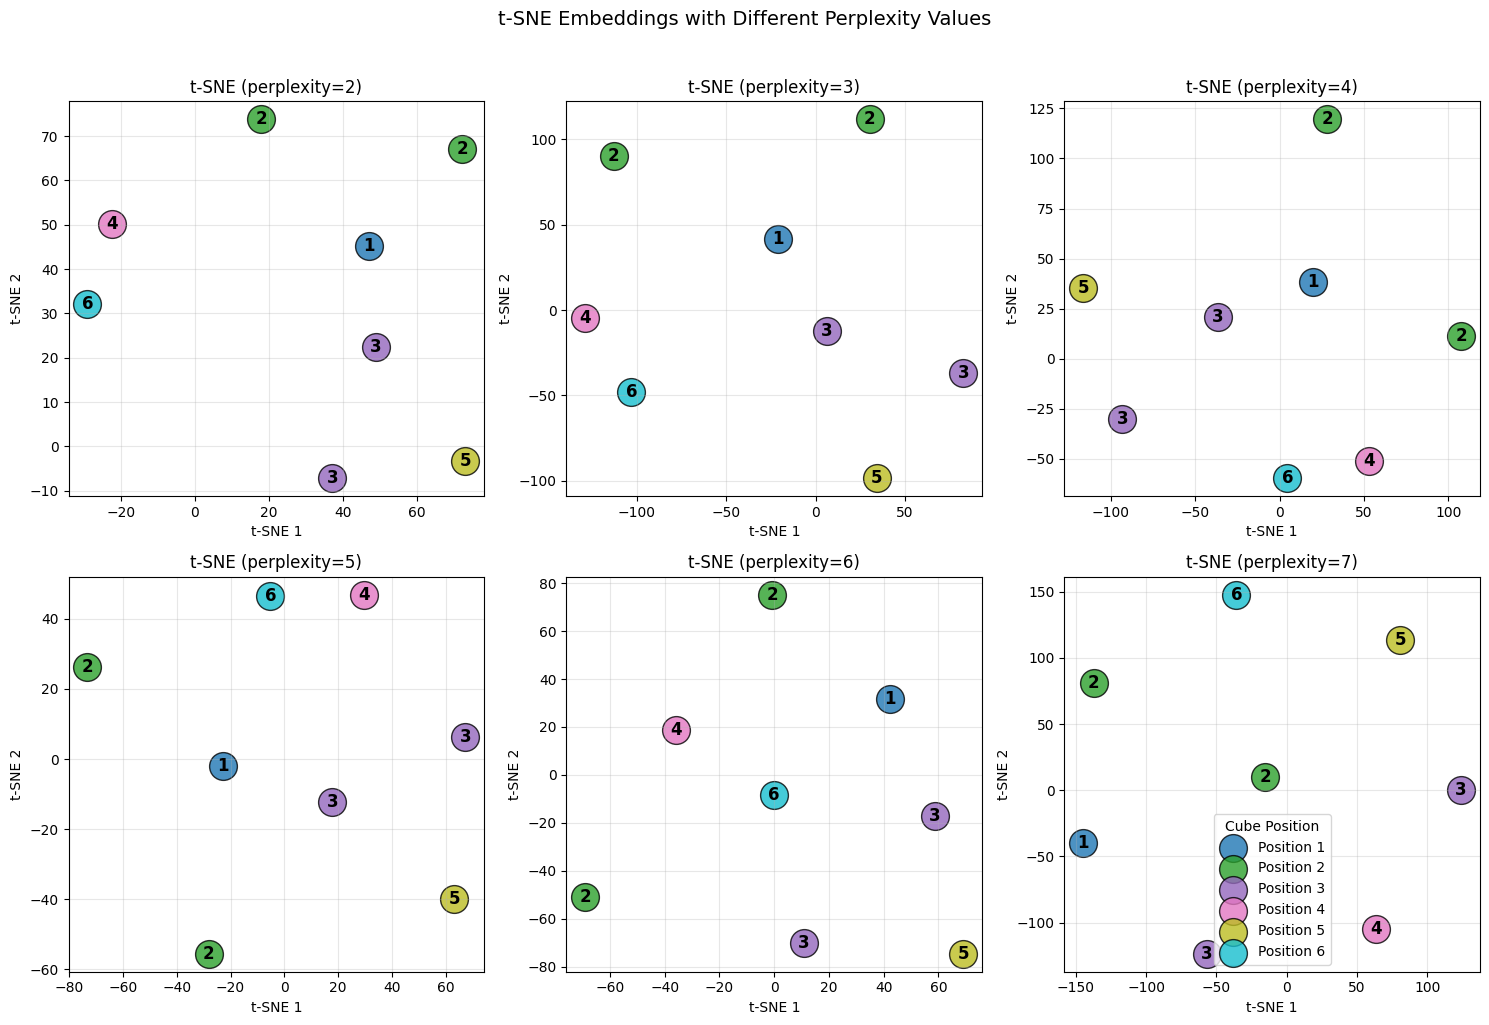

In [11]:
# Try different perplexity values
# Perplexity should be less than n_samples, typically 5-50
perplexities = [2, 3, 4, 5, 6, 7]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

tsne_embeddings = {}

for idx, perp in enumerate(perplexities):
    ax = axes[idx]

    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=perp, random_state=RANDOM_SEED, max_iter=1000)
    X_tsne = tsne.fit_transform(X_pca_pre)
    tsne_embeddings[perp] = X_tsne

    # Plot
    for pos in unique_positions:
        mask = positions == pos
        ax.scatter(
            X_tsne[mask, 0],
            X_tsne[mask, 1],
            c=[color_map[pos]],
            label=f'Position {pos}',
            s=400,
            alpha=0.8,
            edgecolors='black',
            linewidths=1
        )

    # Add position labels
    for i, (x, y) in enumerate(X_tsne):
        ax.text(x, y, str(positions[i]),
                fontsize=12, fontweight='bold',
                ha='center', va='center', color='black')

    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_title(f't-SNE (perplexity={perp})')
    ax.grid(True, alpha=0.3)

# Add legend to last plot
axes[-1].legend(title='Cube Position', loc='best')

plt.suptitle('t-SNE Embeddings with Different Perplexity Values', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## t-SNE 3D Visualization

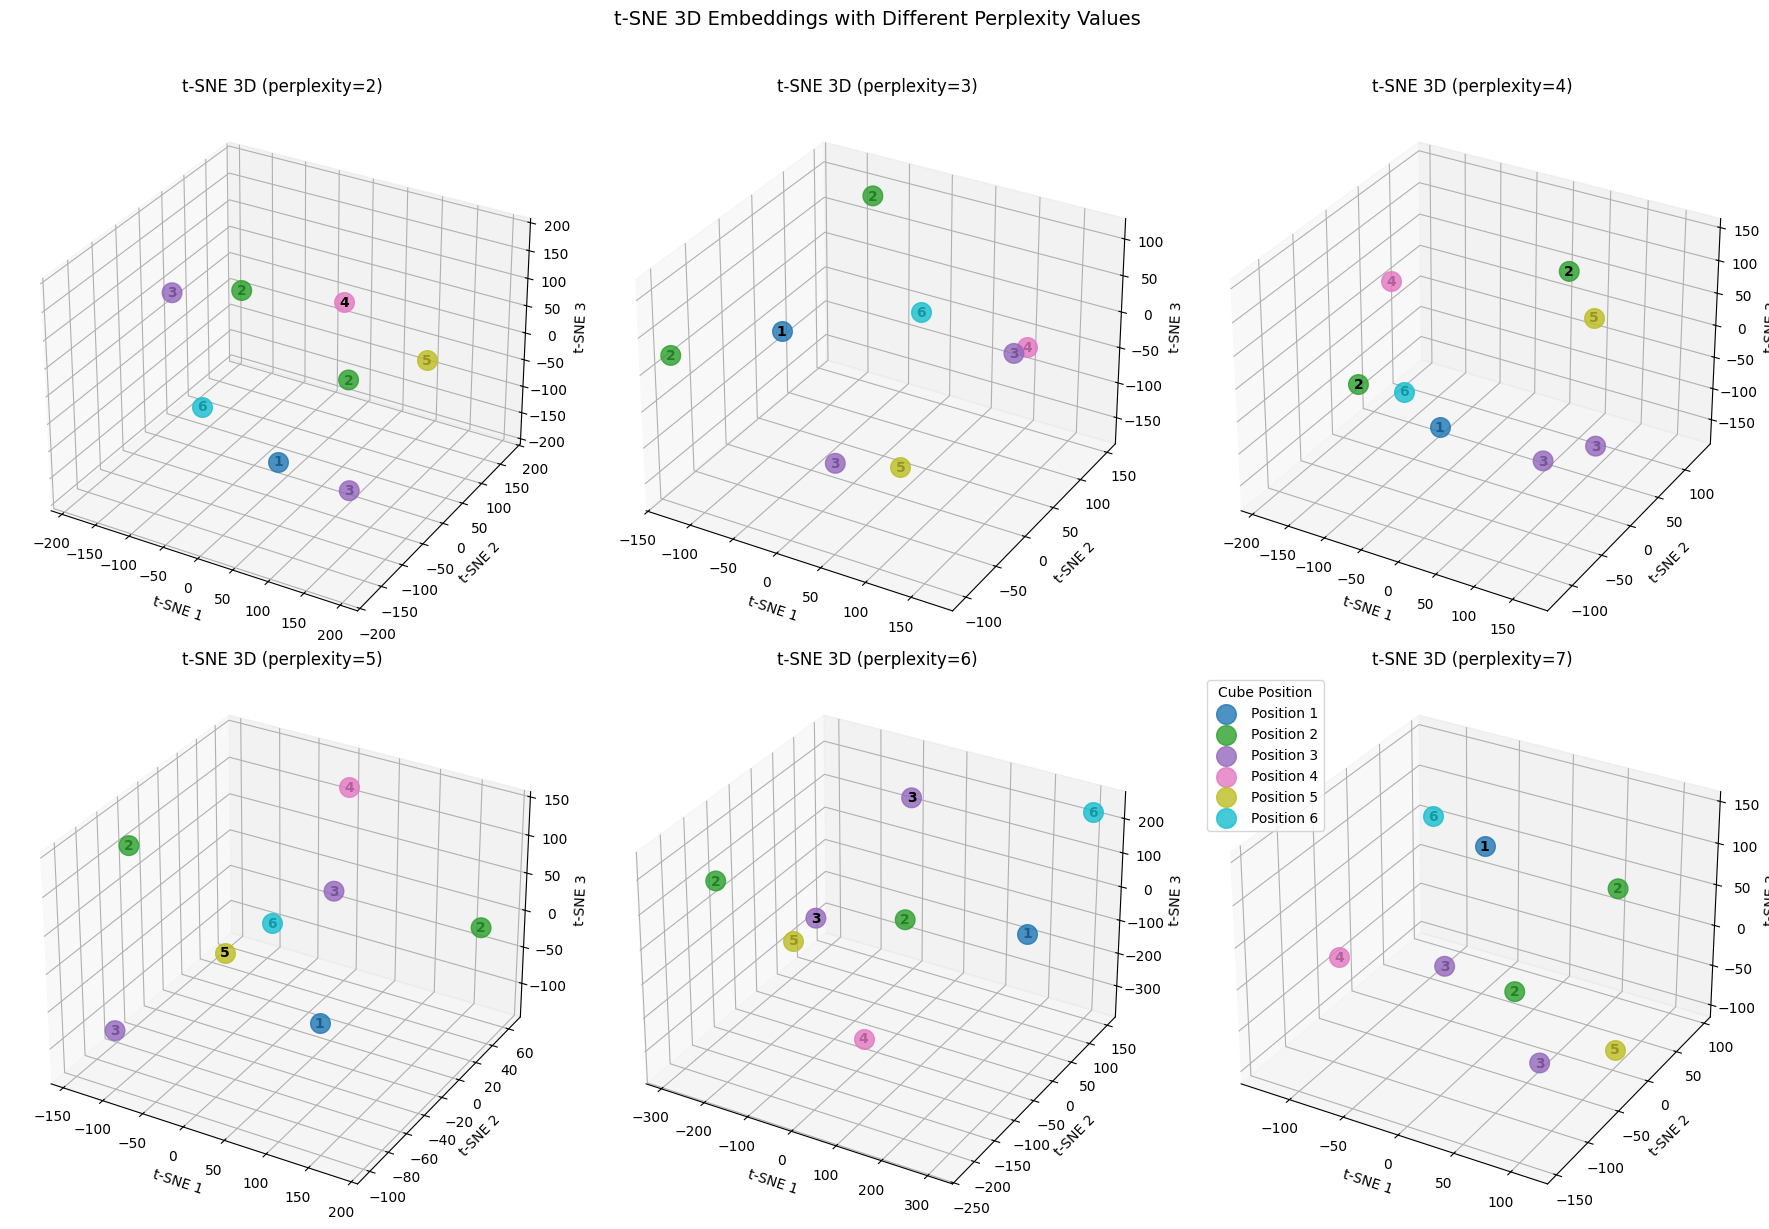

In [12]:
# t-SNE to 3 dimensions with different perplexity values
perplexities_3d = [2, 3, 4, 5, 6, 7]

fig = plt.figure(figsize=(18, 12))

tsne_embeddings_3d = {}

for idx, perp in enumerate(perplexities_3d):
    ax = fig.add_subplot(2, 3, idx + 1, projection='3d')

    # Run t-SNE to 3D
    tsne_3d = TSNE(n_components=3, perplexity=perp, random_state=RANDOM_SEED, max_iter=1000)
    X_tsne_3d = tsne_3d.fit_transform(X_pca_pre)
    tsne_embeddings_3d[perp] = X_tsne_3d

    # Plot
    for pos in unique_positions:
        mask = positions == pos
        ax.scatter(
            X_tsne_3d[mask, 0],
            X_tsne_3d[mask, 1],
            X_tsne_3d[mask, 2],
            c=[color_map[pos]],
            label=f'Position {pos}',
            s=200,
            alpha=0.8
        )

    # Add position labels to each point
    for i in range(len(positions)):
        ax.text(
            X_tsne_3d[i, 0],
            X_tsne_3d[i, 1],
            X_tsne_3d[i, 2],
            str(positions[i]),
            fontsize=10,
            fontweight='bold',
            ha='center',
            va='center',
            color='black'
        )

    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_zlabel('t-SNE 3')
    ax.set_title(f't-SNE 3D (perplexity={perp})')

# Add legend to last plot
ax.legend(title='Cube Position', loc='upper left')

plt.suptitle('t-SNE 3D Embeddings with Different Perplexity Values', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## t-SNE Distance Matrix with Ordering Validation

Varying number of dimensions (like PCA), with fixed perplexity=5.

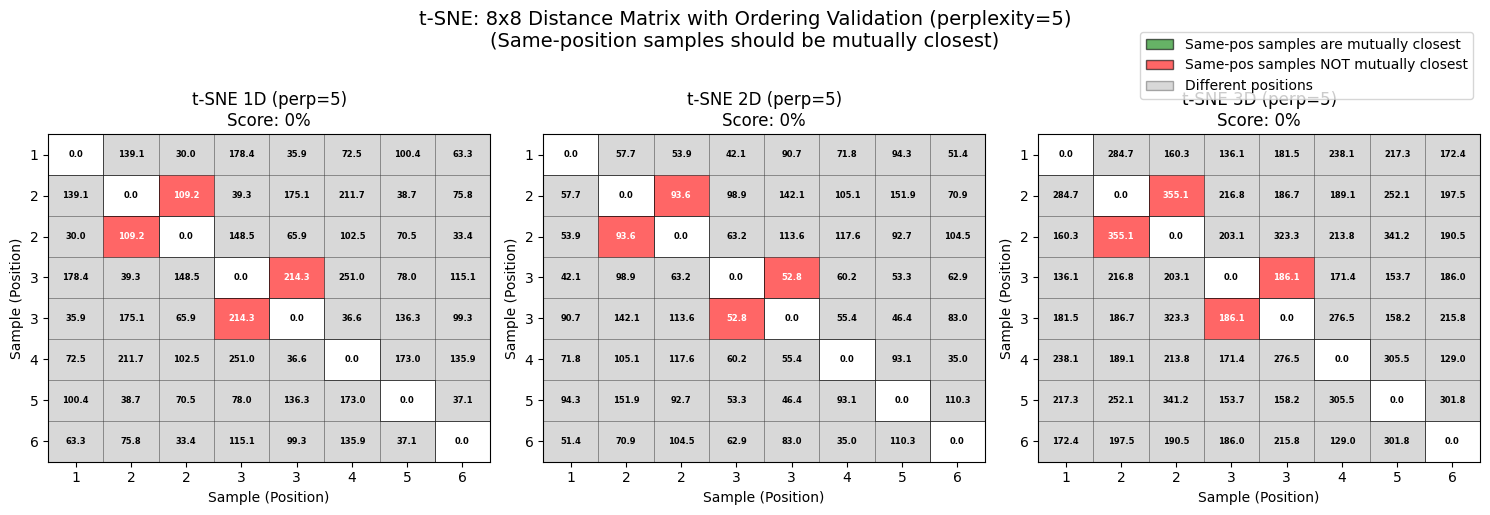


t-SNE Scores by dimension (perplexity=5):
  1D: 0%
  2D: 0%
  3D: 0%


In [13]:
# Distance matrices with ordering validation for t-SNE embeddings
# Vary number of dimensions (1-3) with fixed perplexity=5
# Note: t-SNE Barnes-Hut only supports up to 3 dimensions
TSNE_PERPLEXITY = 5
max_tsne_dims = 3

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

tsne_scores = []
tsne_embeddings_by_dim = {}

for n_dims in range(1, max_tsne_dims + 1):
    ax = axes[n_dims - 1]

    # Run t-SNE to n_dims dimensions
    tsne = TSNE(n_components=n_dims, perplexity=TSNE_PERPLEXITY, random_state=RANDOM_SEED, max_iter=1000)
    X_tsne = tsne.fit_transform(X_pca_pre)
    tsne_embeddings_by_dim[n_dims] = X_tsne

    dist_matrix = compute_sample_distance_matrix(X_tsne)
    score, status_matrix = check_same_position_closest(dist_matrix, positions)
    tsne_scores.append((n_dims, score))

    n_samples = len(sample_labels)

    # Plot with colored cells based on status
    for i in range(n_samples):
        for j in range(n_samples):
            if i == j:
                color, alpha = 'white', 1.0
            elif status_matrix[i, j] == 1:
                color, alpha = 'green', 0.6
            elif status_matrix[i, j] == -1:
                color, alpha = 'red', 0.6
            else:
                color, alpha = 'gray', 0.3

            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                  facecolor=color, alpha=alpha, edgecolor='black', linewidth=0.5)
            ax.add_patch(rect)

            text_color = 'white' if status_matrix[i, j] != 0 else 'black'
            ax.text(j, i, f'{dist_matrix[i, j]:.1f}',
                   ha='center', va='center', color=text_color, fontsize=6, fontweight='bold')

    ax.set_xticks(range(n_samples))
    ax.set_yticks(range(n_samples))
    ax.set_xticklabels(sample_labels)
    ax.set_yticklabels(sample_labels)
    ax.set_xlabel('Sample (Position)')
    ax.set_ylabel('Sample (Position)')
    ax.set_title(f't-SNE {n_dims}D (perp={TSNE_PERPLEXITY})\nScore: {score:.0%}')
    ax.set_xlim(-0.5, n_samples - 0.5)
    ax.set_ylim(n_samples - 0.5, -0.5)

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99))
plt.suptitle(f't-SNE: 8x8 Distance Matrix with Ordering Validation (perplexity={TSNE_PERPLEXITY})\n(Same-position samples should be mutually closest)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nt-SNE Scores by dimension (perplexity={TSNE_PERPLEXITY}):")
for n_dims, score in tsne_scores:
    print(f"  {n_dims}D: {score:.0%}")

---
# Diffusion Map Analysis

Diffusion maps use a graph-based approach to capture the intrinsic geometry of the data manifold.

In [14]:
from scipy.spatial.distance import pdist, squareform

def diffusion_map(X, n_components=8, alpha=1.0, t=1):
    """
    Compute diffusion map embedding.

    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Input data
    n_components : int
        Number of diffusion coordinates to compute
    alpha : float
        Normalization parameter (0 to 1). alpha=1 gives normalized graph Laplacian.
    t : int
        Diffusion time (number of steps)

    Returns:
    --------
    embedding : array, shape (n_samples, n_components)
        Diffusion map coordinates
    eigenvalues : array
        Eigenvalues of the diffusion operator
    """
    n_samples = X.shape[0]

    # Compute pairwise distances
    distances = squareform(pdist(X, metric='euclidean'))

    # Compute kernel bandwidth using median heuristic
    epsilon = np.median(distances[distances > 0]) ** 2

    # Compute Gaussian kernel
    K = np.exp(-distances ** 2 / epsilon)

    # Normalize kernel (alpha normalization)
    if alpha > 0:
        d = K.sum(axis=1)
        K = K / np.outer(d ** alpha, d ** alpha)

    # Row normalize to get transition matrix
    row_sums = K.sum(axis=1)
    P = K / row_sums[:, np.newaxis]

    # Compute eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eig(P)

    # Sort by eigenvalue (descending)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx].real
    eigenvectors = eigenvectors[:, idx].real

    # Skip the first eigenvalue (always 1) and take the next n_components
    n_components = min(n_components, n_samples - 1)
    eigenvalues = eigenvalues[1:n_components + 1]
    eigenvectors = eigenvectors[:, 1:n_components + 1]

    # Scale by eigenvalues raised to power t (diffusion time)
    embedding = eigenvectors * (eigenvalues ** t)

    return embedding, eigenvalues

# Compute diffusion map with 8 components (we have 8 samples, so max 7 non-trivial components)
max_dm_components = min(8, X.shape[0] - 1)  # 7 components for 8 samples
X_dm, dm_eigenvalues = diffusion_map(X_normalized, n_components=max_dm_components, alpha=1.0, t=1)

print(f"Diffusion map embedding shape: {X_dm.shape}")
print(f"Eigenvalues: {dm_eigenvalues}")
print(f"Number of components: {X_dm.shape[1]}")

Diffusion map embedding shape: (8, 7)
Eigenvalues: [0.24320709 0.20240419 0.19266125 0.17326565 0.17052792 0.14780869
 0.12933256]
Number of components: 7


## Diffusion Map 2D and 3D Visualization

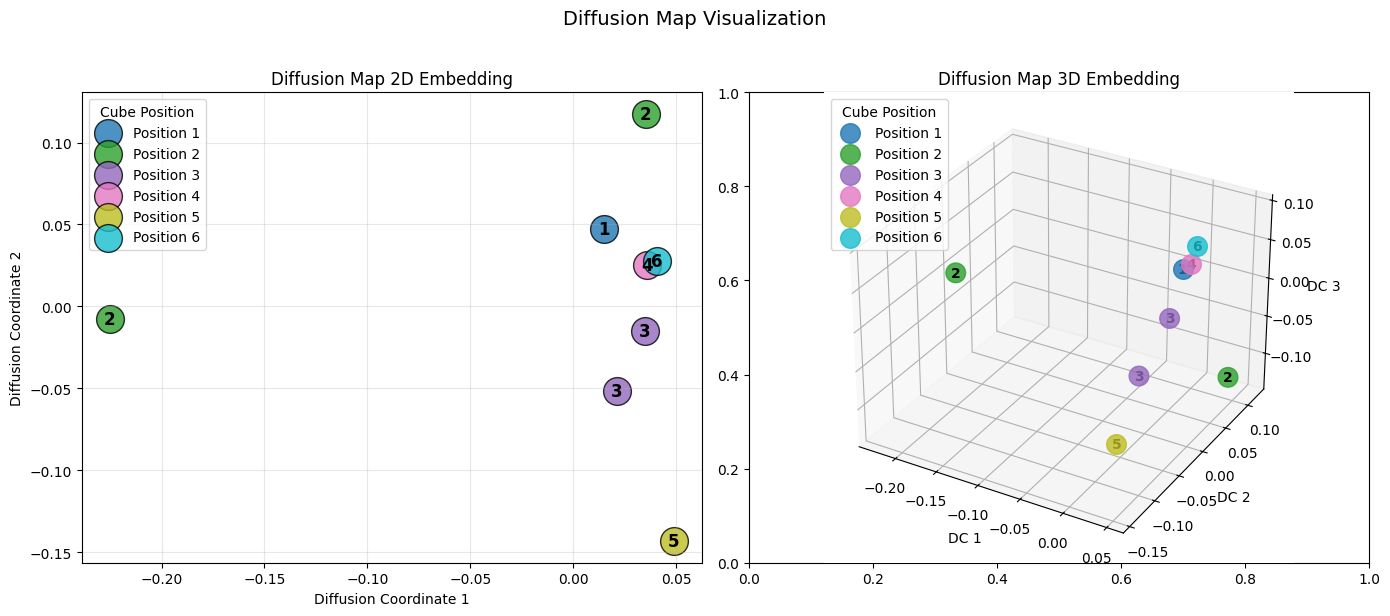

In [15]:
# 2D Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 2D plot (dimensions 1 and 2, which are indices 0 and 1)
ax = axes[0]
for pos in unique_positions:
    mask = positions == pos
    ax.scatter(
        X_dm[mask, 0],
        X_dm[mask, 1],
        c=[color_map[pos]],
        label=f'Position {pos}',
        s=400,
        alpha=0.8,
        edgecolors='black',
        linewidths=1
    )

# Add position labels
for i, (x, y) in enumerate(X_dm[:, :2]):
    ax.text(x, y, str(positions[i]),
            fontsize=12, fontweight='bold',
            ha='center', va='center', color='black')

ax.set_xlabel('Diffusion Coordinate 1')
ax.set_ylabel('Diffusion Coordinate 2')
ax.set_title('Diffusion Map 2D Embedding')
ax.legend(title='Cube Position', loc='best')
ax.grid(True, alpha=0.3)

# 3D plot (dimensions 1, 2, and 3)
ax = fig.add_subplot(1, 2, 2, projection='3d')
for pos in unique_positions:
    mask = positions == pos
    ax.scatter(
        X_dm[mask, 0],
        X_dm[mask, 1],
        X_dm[mask, 2],
        c=[color_map[pos]],
        label=f'Position {pos}',
        s=200,
        alpha=0.8
    )

# Add position labels to each point
for i in range(len(positions)):
    ax.text(
        X_dm[i, 0],
        X_dm[i, 1],
        X_dm[i, 2],
        str(positions[i]),
        fontsize=10,
        fontweight='bold',
        ha='center',
        va='center',
        color='black'
    )

ax.set_xlabel('DC 1')
ax.set_ylabel('DC 2')
ax.set_zlabel('DC 3')
ax.set_title('Diffusion Map 3D Embedding')
ax.legend(title='Cube Position', loc='upper left')

plt.suptitle('Diffusion Map Visualization', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Diffusion Map Distance Matrix with Ordering Validation

Check if same-position samples are mutually closest in the diffusion map embedding space.

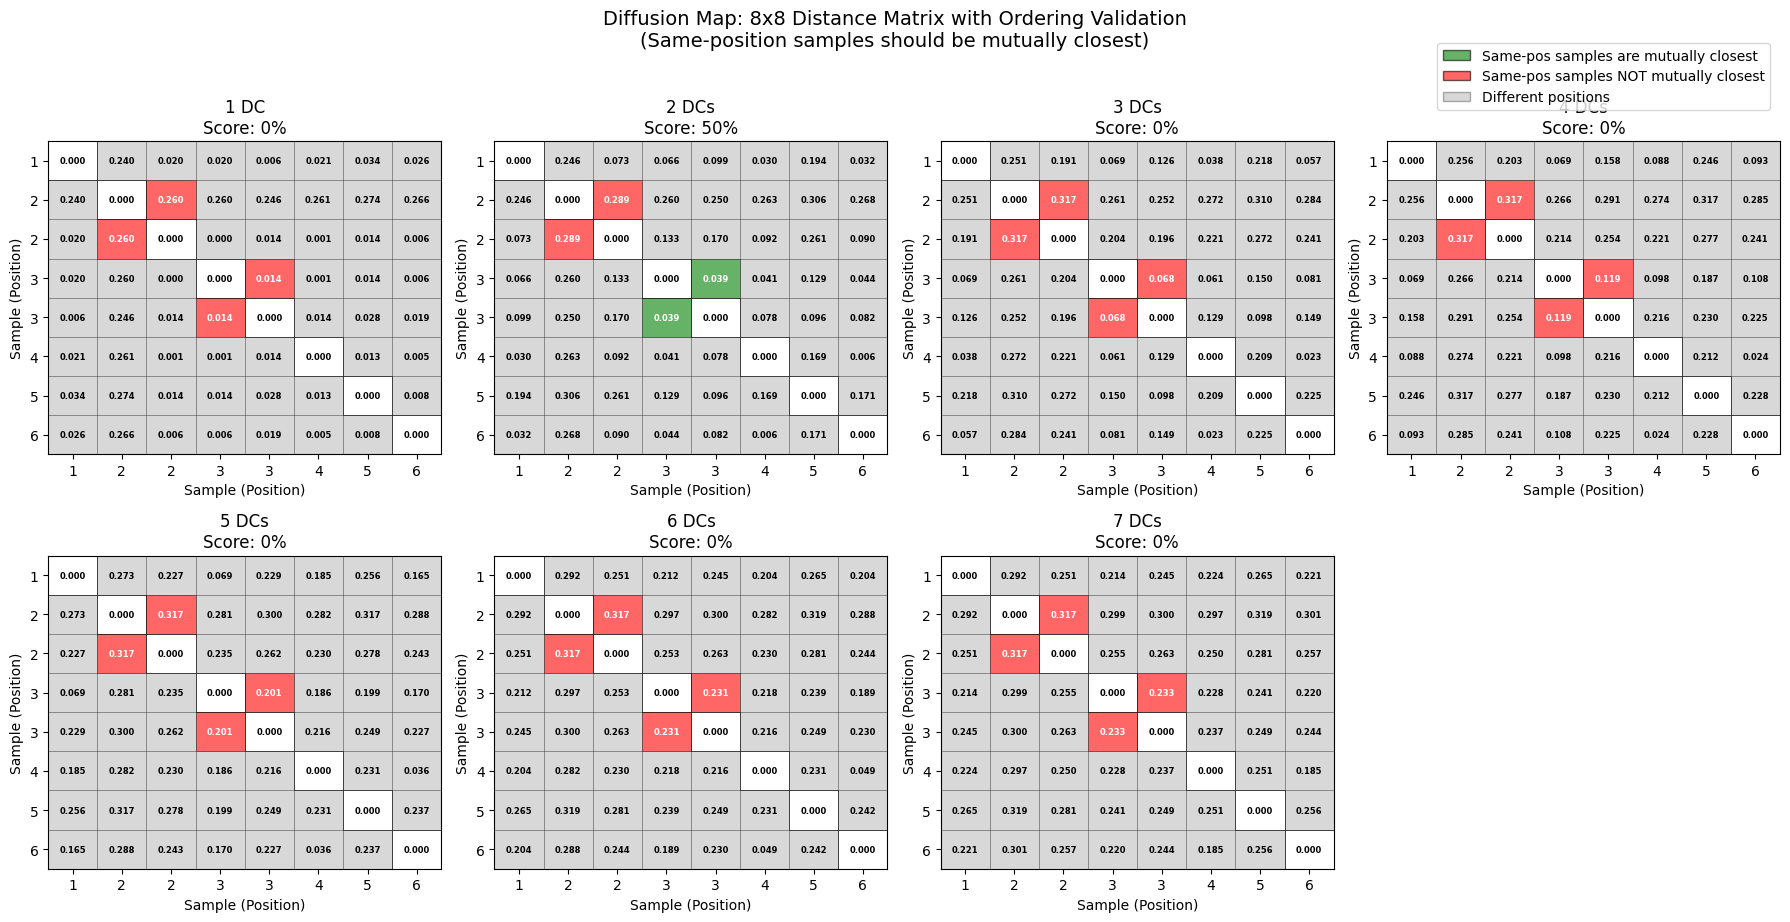


Diffusion Map Scores (same-position samples mutually closest):
  1 DC : 0%
  2 DCs: 50%
  3 DCs: 0%
  4 DCs: 0%
  5 DCs: 0%
  6 DCs: 0%
  7 DCs: 0%


In [16]:
# Distance matrices with ordering validation for diffusion map embeddings
# Vary number of dimensions (1-7, since we have 8 samples and max 7 non-trivial components)
n_dm_dims = X_dm.shape[1]  # 7 components

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

dm_scores = []

for n_dims in range(1, min(n_dm_dims + 1, 8)):
    ax = axes[n_dims - 1]
    X_subset = X_dm[:, :n_dims]
    dist_matrix = compute_sample_distance_matrix(X_subset)
    score, status_matrix = check_same_position_closest(dist_matrix, positions)
    dm_scores.append(score)

    n_samples = len(sample_labels)

    # Plot with colored cells based on status
    for i in range(n_samples):
        for j in range(n_samples):
            if i == j:
                color, alpha = 'white', 1.0
            elif status_matrix[i, j] == 1:
                color, alpha = 'green', 0.6
            elif status_matrix[i, j] == -1:
                color, alpha = 'red', 0.6
            else:
                color, alpha = 'gray', 0.3

            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                  facecolor=color, alpha=alpha, edgecolor='black', linewidth=0.5)
            ax.add_patch(rect)

            text_color = 'white' if status_matrix[i, j] != 0 else 'black'
            ax.text(j, i, f'{dist_matrix[i, j]:.3f}',
                   ha='center', va='center', color=text_color, fontsize=6, fontweight='bold')

    ax.set_xticks(range(n_samples))
    ax.set_yticks(range(n_samples))
    ax.set_xticklabels(sample_labels)
    ax.set_yticklabels(sample_labels)
    ax.set_xlabel('Sample (Position)')
    ax.set_ylabel('Sample (Position)')
    ax.set_title(f'{n_dims} DC{"s" if n_dims > 1 else ""}\nScore: {score:.0%}')
    ax.set_xlim(-0.5, n_samples - 0.5)
    ax.set_ylim(n_samples - 0.5, -0.5)

# Hide the 8th subplot if we only have 7 components
if n_dm_dims < 8:
    axes[7].axis('off')

# Add legend
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99))

plt.suptitle('Diffusion Map: 8x8 Distance Matrix with Ordering Validation\n(Same-position samples should be mutually closest)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nDiffusion Map Scores (same-position samples mutually closest):")
for n_dims, score in enumerate(dm_scores, 1):
    print(f"  {n_dims} DC{'s' if n_dims > 1 else ' '}: {score:.0%}")

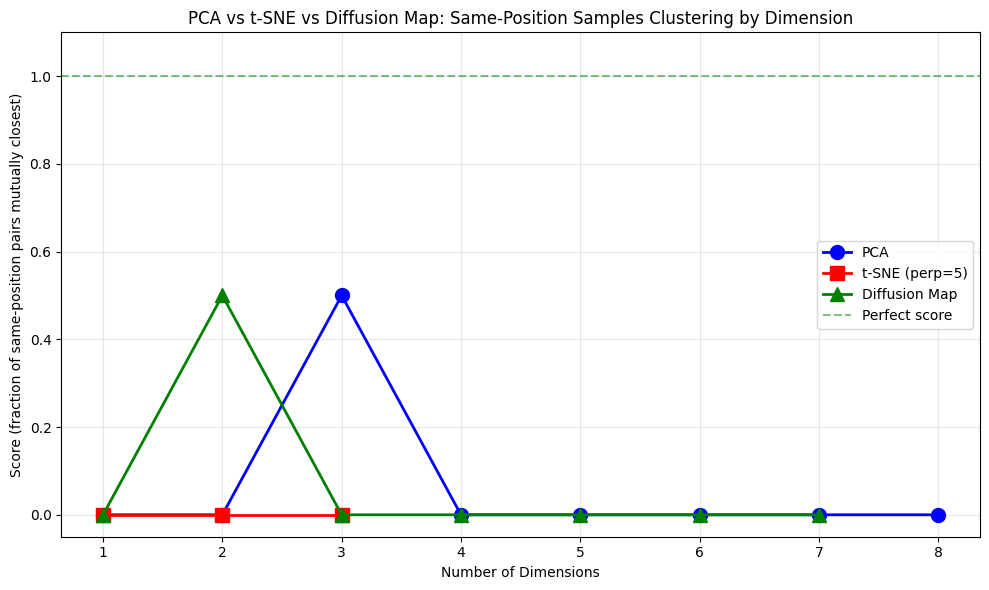


SUMMARY: Same-Position Clustering Score
(Samples from same position should be mutually closest)

PCA:
  1D: 0%
  2D: 0%
  3D: 50%
  4D: 0%
  5D: 0%
  6D: 0%
  7D: 0%
  8D: 0%
  Best: 50% at 3D

t-SNE (perplexity=5, max 3D due to Barnes-Hut):
  1D: 0%
  2D: 0%
  3D: 0%
  Best: 0% at 1D

Diffusion Map:
  1D: 0%
  2D: 50%
  3D: 0%
  4D: 0%
  5D: 0%
  6D: 0%
  7D: 0%
  Best: 50% at 2D


In [17]:
# Compare PCA, t-SNE, and Diffusion Map scores by number of dimensions
fig, ax = plt.subplots(figsize=(10, 6))

# PCA scores (1-8 dimensions)
pca_x = list(range(1, len(pca_scores) + 1))
ax.plot(pca_x, pca_scores, 'b-o', label='PCA', markersize=10, linewidth=2)

# t-SNE scores (1-3 dimensions only, due to Barnes-Hut limitation)
tsne_x = [d for d, _ in tsne_scores]
tsne_y = [s for _, s in tsne_scores]
ax.plot(tsne_x, tsne_y, 'r-s', label=f't-SNE (perp={TSNE_PERPLEXITY})', markersize=10, linewidth=2)

# Diffusion Map scores (1-7 dimensions)
dm_x = list(range(1, len(dm_scores) + 1))
ax.plot(dm_x, dm_scores, 'g-^', label='Diffusion Map', markersize=10, linewidth=2)

ax.set_xlabel('Number of Dimensions')
ax.set_ylabel('Score (fraction of same-position pairs mutually closest)')
ax.set_title('PCA vs t-SNE vs Diffusion Map: Same-Position Samples Clustering by Dimension')
ax.set_ylim(-0.05, 1.1)
ax.set_xticks(range(1, 9))
ax.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='Perfect score')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 60)
print("SUMMARY: Same-Position Clustering Score")
print("(Samples from same position should be mutually closest)")
print("=" * 60)
print("\nPCA:")
for n_dims, score in enumerate(pca_scores, 1):
    print(f"  {n_dims}D: {score:.0%}")
print(f"  Best: {max(pca_scores):.0%} at {pca_scores.index(max(pca_scores)) + 1}D")

print(f"\nt-SNE (perplexity={TSNE_PERPLEXITY}, max 3D due to Barnes-Hut):")
for n_dims, score in tsne_scores:
    print(f"  {n_dims}D: {score:.0%}")
best_tsne = max(tsne_scores, key=lambda x: x[1])
print(f"  Best: {best_tsne[1]:.0%} at {best_tsne[0]}D")

print(f"\nDiffusion Map:")
for n_dims, score in enumerate(dm_scores, 1):
    print(f"  {n_dims}D: {score:.0%}")
print(f"  Best: {max(dm_scores):.0%} at {dm_scores.index(max(dm_scores)) + 1}D")
print("=" * 60)